# 時系列解析で分類

まずは１変数でニューラルネットワークを使用した時系列の分類問題の実装を行ってみましょう。

## １変数のNNを使用

まずは時系列向けのRecurrent Neural Network（RNN）ではなく、全結合のNeural Networkを使用してみましょう。

### モジュール及びデータの準備

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from pandas_datareader.yahoo.daily import YahooDailyReader
import datetime

In [3]:
date_st = datetime.datetime(2015, 1, 1)
date_fn = datetime.datetime(2020,1,1)

In [4]:
df1 = YahooDailyReader('MSFT', date_st, date_fn).read().reset_index()

In [5]:
df1.head(3)

,Date,High,Low,Open,Close,Volume,Adj Close
0,2014-12-31,47.439999,46.450001,46.730000,46.450001,21552500.0,41.700874
1,2015-01-02,47.419998,46.540001,46.660000,46.759998,27913900.0,41.979183
2,2015-01-05,46.730000,46.250000,46.369999,46.330002,39673900.0,41.593143


In [6]:
ts = df1['Close'].values

In [7]:
ts

array([ 46.45000076,  46.75999832,  46.33000183, ..., 158.96000671,
       157.58999634, 157.69999695])

In [8]:
ts.shape

(1259,)

### 教師データの作成

時系列解析では、手元にあるデータからいかに素早く教師データを作成できるかがポイントになります。
下記の例では翌日の価格が上昇すれば1, 下降もしくは同じであれば0といったようなラベル付けを行います。

xとtにまずはリスト形式でデータを格納していきます。

In [9]:
x, t = [], []
for i in range(len(ts)-1):
    x.append(ts[i])
    if ts[i] < ts[i+1]:  # 今日より明日の方がよければ
        t.append(1)
    else:
        t.append(0)

最終的にまとまった結果をNumpyにしておきましょう。

In [10]:
x = np.array(x).reshape(len(x), 1)
t = np.array(t)

In [11]:
x.shape

(1258, 1)

### データセットの作成と訓練・検証データへ分割

In [12]:
# try:
#   # Colab only
#   %tensorflow_version 2.x
# except Exception:
#     pass

# Pythonの挙動を整えるライブラリのインポート
from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow と tf.keras のインポート
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import models,layers

訓練と検証データを分割する際に絶対に注意すべき点として、` train_test_split`の引数を`shuffle=False`としておくことです。
ランダムに抽出してしまうと、時系列データが切れてしまいます。また、この際に `random_state=0`は必要ありません。

In [13]:
from sklearn.model_selection import train_test_split

# 訓練データと検証データの分割
train_x, val_x, train_t, val_t = train_test_split(x, t, test_size=0.3, shuffle=False)

では分割したデータを確認しましょう。

### モデルの定義

NNのモデルに関しては、これまでと変わりはありません。

In [14]:
import os
import random


def reset_seed(seed=0):

    os.environ['PYTHONHASHSEED'] = '0'
    random.seed(seed) #　random関数のシードを固定
    np.random.seed(seed) #numpyのシードを固定
    tf.random.set_seed(seed) #tensorflowのシードを固定

In [15]:
reset_seed(0)

model = models.Sequential()

model.add(layers.Dense(10, input_shape=(1,), activation='relu'))
model.add(layers.Dense(2, activation='softmax'))

optimizer = keras.optimizers.SGD(lr=0.01)

model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [16]:
history = model.fit(train_x, train_t,
          batch_size=100,
          epochs=20,
          verbose=1,
          validation_data=(val_x, val_t),shuffle=False)

Train on 880 samples, validate on 378 samples
Epoch 1/20
880/880 [==============================] - 1s 867us/sample - loss: 8.5951 - accuracy: 0.4966 - val_loss: 9.2119 - val_accuracy: 0.5741
Epoch 2/20
880/880 [==============================] - 0s 37us/sample - loss: 1.2019 - accuracy: 0.4966 - val_loss: 1.2456 - val_accuracy: 0.5741
Epoch 3/20
880/880 [==============================] - 0s 37us/sample - loss: 0.7204 - accuracy: 0.4920 - val_loss: 1.2454 - val_accuracy: 0.5741
Epoch 4/20
880/880 [==============================] - 0s 37us/sample - loss: 0.7156 - accuracy: 0.4830 - val_loss: 0.8236 - val_accuracy: 0.5741
Epoch 5/20
880/880 [==============================] - 0s 39us/sample - loss: 0.7013 - accuracy: 0.4920 - val_loss: 0.7305 - val_accuracy: 0.5741
Epoch 6/20
880/880 [==============================] - 0s 36us/sample - loss: 0.6976 - accuracy: 0.4920 - val_loss: 0.6986 - val_accuracy: 0.5741
Epoch 7/20
880/880 [==============================] - 0s 38us/sample - loss: 0.6959

In [17]:
# 学習結果をPandasのDataFrame型で読み込みます。
results = pd.DataFrame(history.history)

In [18]:
results

,loss,accuracy,val_loss,val_accuracy
0,8.595129,0.496591,9.211945,0.574074
1,1.201868,0.496591,1.245622,0.574074
2,0.720429,0.492045,1.245445,0.574074
3,0.715603,0.482955,0.823644,0.574074
4,0.701327,0.492045,0.730455,0.574074
5,0.697615,0.492045,0.698604,0.574074
6,0.695921,0.498864,0.686597,0.574074
7,0.694961,0.498864,0.682882,0.574074
8,0.694354,0.498864,0.683169,0.574074
9,0.693945,0.498864,0.685556,0.574074


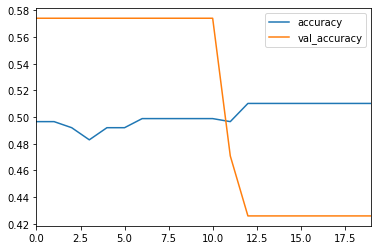

In [19]:
# accuracy（精度）を表示
results[['accuracy', 'val_accuracy']].plot()

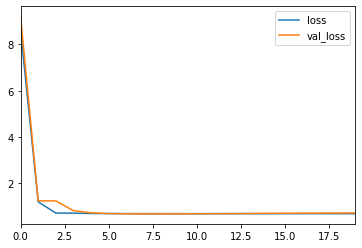

In [20]:
# loss（損失関数）を表示
results[['loss', 'val_loss']].plot()

全く学習が進んでいません。また最終的なAccuracyは訓練データに対して50%が得られていますが、検証データに対して約45%であるため、確率1/2よりもよくない結果となってしまっています。

## LSTM（RNN）

時系列解析向けのNNでありRNNの一種であるLong-Short Term Memory（LSTM）を使用して結果の改善が見込まれるか試してみましょう。

大きな変更点は `LSTM(10, input_shape=(1, 1), activation='relu')`の部分です。
これまでは、`Dense(10, input_shape=(1, ), activation='relu')`のように全結合層を設けていましたが、こちらを`LSTM`として定義するだけでLSTMの層になります。
１点だけLSTMを使用する際に気をつけるべき点があります。
LSTMでは入力が`input_shape=(1, 1)`と二次元になっています。これはデータが二次元配列で入ってくることが前提となっているためです。ですので入力`x`を整形しましょう。

In [21]:
x = np.array(x).reshape(len(x), 1, 1)

In [22]:
x.shape

(1258, 1, 1)

In [23]:
# 訓練データと検証データの分割
train_x, val_x, train_t, val_t = train_test_split(x, t, test_size=0.3, shuffle=False)

In [24]:
import os
import random


def reset_seed(seed=0):

    os.environ['PYTHONHASHSEED'] = '0'
    random.seed(seed) #　random関数のシードを固定
    np.random.seed(seed) #numpyのシードを固定
    tf.random.set_seed(seed) #tensorflowのシードを固定

In [25]:
reset_seed(0)

model = models.Sequential()

model.add(layers.LSTM(10, input_shape=(1, 1), activation='relu'))
model.add(layers.Dense(2, activation='softmax'))

optimizer = keras.optimizers.Adam(lr=0.01)

model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [26]:
history = model.fit(train_x, train_t,
          batch_size=100,
          epochs=20,
          verbose=1,
          validation_data=(val_x, val_t), shuffle=False)

Train on 880 samples, validate on 378 samples
Epoch 1/20
880/880 [==============================] - 2s 2ms/sample - loss: 1.0016 - accuracy: 0.5330 - val_loss: 1.0693 - val_accuracy: 0.5741
Epoch 2/20
880/880 [==============================] - 0s 55us/sample - loss: 0.7244 - accuracy: 0.4670 - val_loss: 0.6988 - val_accuracy: 0.4259
Epoch 3/20
880/880 [==============================] - 0s 53us/sample - loss: 0.7038 - accuracy: 0.5159 - val_loss: 0.6908 - val_accuracy: 0.5741
Epoch 4/20
880/880 [==============================] - 0s 62us/sample - loss: 0.6946 - accuracy: 0.5205 - val_loss: 0.6884 - val_accuracy: 0.5741
Epoch 5/20
880/880 [==============================] - 0s 53us/sample - loss: 0.6930 - accuracy: 0.5216 - val_loss: 0.6855 - val_accuracy: 0.5741
Epoch 6/20
880/880 [==============================] - 0s 54us/sample - loss: 0.6925 - accuracy: 0.5114 - val_loss: 0.6843 - val_accuracy: 0.5741
Epoch 7/20
880/880 [==============================] - 0s 57us/sample - loss: 0.6915 -

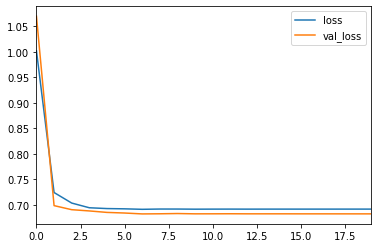

In [27]:
# 学習結果をPandasのDataFrame型で読み込みます。
results = pd.DataFrame(history.history)

# loss（損失関数）を表示
results[['loss', 'val_loss']].plot()

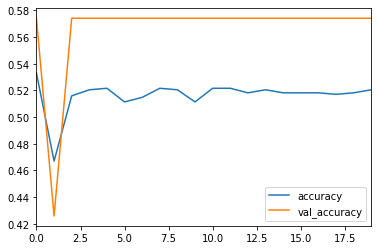

In [28]:
# accuracy（精度）を表示
results[['accuracy', 'val_accuracy']].plot()

シンプルなモデルではうまくいかないようでした。   
層を深くしたり、ノードの数を調整することによって精度に変化があるのか確認してみましょう。

## 演習


前章で紹介した方法で複数社の株価を取得し、１変数ではなく複数の変数を使用して上下の予測を行うように変更して変化があるか検証しましょう。
また、LSTMの層も１層ではなく複数層を保持するとどのように変化するか検証しましょう。

さらに発展的な課題としては、LSTMではなくCNNを使用した時系列の解析ができないか検討してみましょう。